Vamos analisar a inflação passada e a atual utilizando o site: https://sidra.ibge.gov.br/home/ipca15/brasil

Essa tarefa é parte de um desafio do site: https://analisemacro.com.br/economia/indicadores/analise-de-dados-de-inflacao-no-python/

In [1]:
# Importar as bibliotecas

!pip install sidrapy
import sidrapy

import numpy as np
import pandas as pd

import datetime as dt

import seaborn as sns

from matplotlib import pyplot as plt

In [2]:
# Aqui veremos as variações do índice IPCA que vem da tabela 1737

ipca_raw = sidrapy.get_table(table_code = '1737',
                            territorial_level = '1',
                            ibge_territorial_code = 'all',
                            variable = '63,69,2263,2264,2265',
                            period = 'last%20472')


In [3]:
# Aqui vamos fazer uma limpeza de dados e manipular a tabela.

ipca =  (
    ipca_raw
    .loc[1:,['V', 'D2C', 'D3N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable'}
            )
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'Var. mensal (%)',
                                                        'IPCA - Variação acumulada no ano': 'Var. acumulada no ano (%)', 
                                                        'IPCA - Variação acumulada em 3 meses' : 'Var. MM3M (%)',
                                                        'IPCA - Variação acumulada em 6 meses': 'Var. MM6M (%)',
                                                        'IPCA - Variação acumulada em 12 meses' : 'Var. MM12M (%)'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float)
           )
    .pipe(lambda x: x.loc[x.date > '2007-01-01']
          )
        )

In [4]:
# Configurar o gráfico

## As cores
colors = ['#282f6b', '#b22200', '#eace3f', '#224f20', '#b35c1e', '#419391', '#839c56','#3b89bc']

## O tamanho
theme = {'figure.figsize' : (15, 10)}

## Aplicar o tema
sns.set_theme(rc = theme,
              palette = colors)

Text(1.0, -0.08, 'Fonte: analisemacro.com.br com dados do Sidra/IBGE')

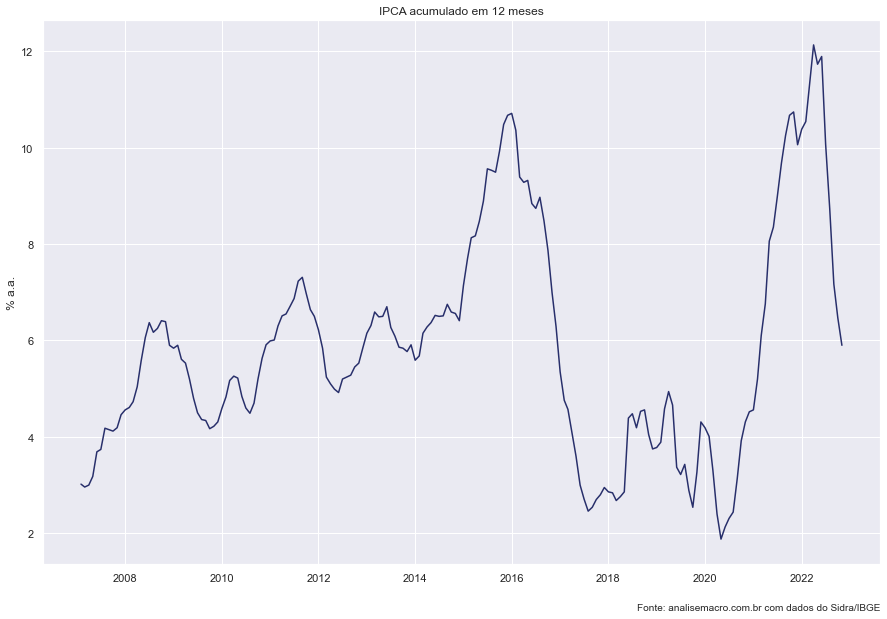

In [5]:
# Filtra somente para o IPCA acumulado em 12 meses

ipca_12m = (   
            ipca
            .pipe(lambda x: x.loc[x.variable == 'Var. MM12M (%)'])
           )

# Plota o IPCA acumulado em 12 meses
sns.lineplot(x = 'date',
             y = 'value',
             data = ipca_12m).set(title = 'IPCA acumulado em 12 meses',
                                                           xlabel = '',
                                                           ylabel = '% a.a.')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: analisemacro.com.br com dados do Sidra/IBGE',
            xy = (1.0, -0.08),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

Text(1.0, -0.13, 'Fonte: analisemacro.com.br com dados do Sidra/IBGE')

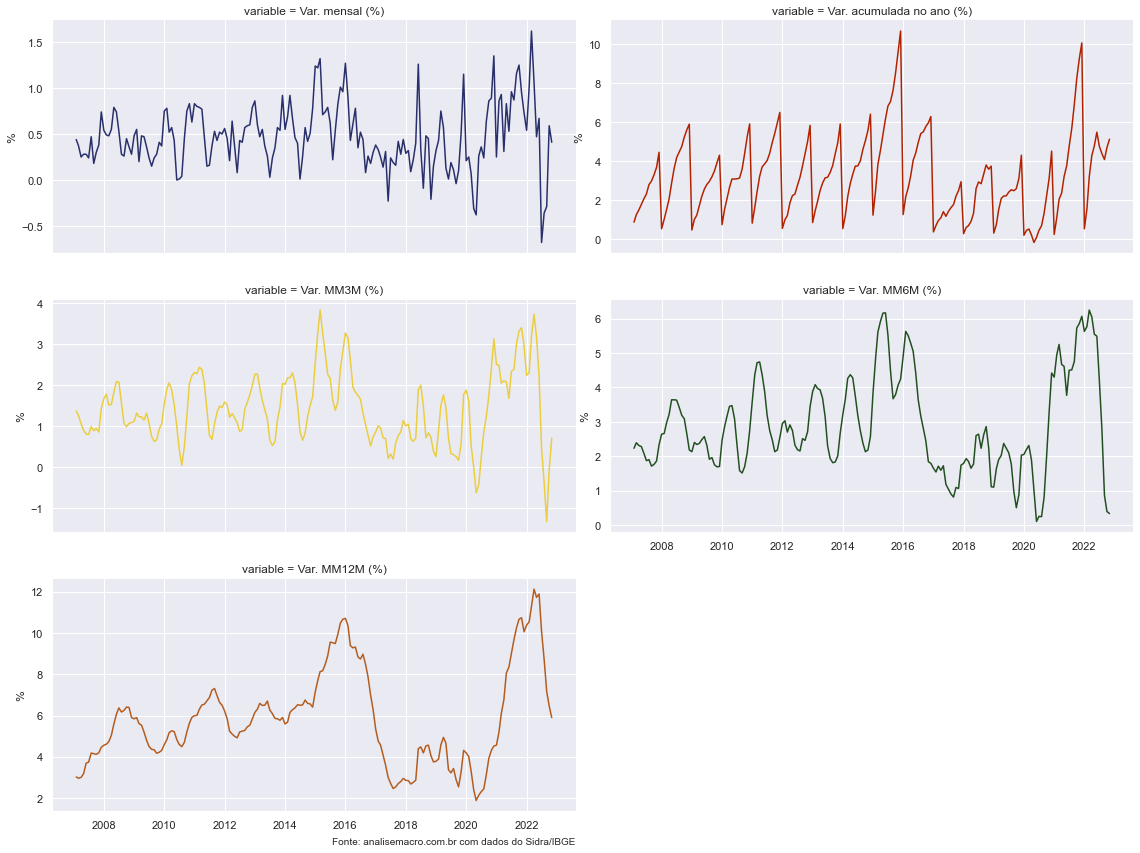

In [6]:
# Plota todas as variações
g = sns.FacetGrid(ipca, col = 'variable',
                  col_wrap = 2,
                  hue = 'variable',
                  sharey = False,
                  height = 4,
                  aspect = 2)


g.map_dataframe(sns.lineplot, 
                x = 'date',
                y = 'value').set(xlabel = "",
                                 ylabel = '%')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: analisemacro.com.br com dados do Sidra/IBGE',
            xy = (1.0, -0.13),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

# Agora vamos analisar a composição por grupo do IPCA.

O Índice de Preços ao Consumidor Amplo é composto por:
    1 - Alimentação e Bebidas;
    2 - Habitação;
    3 - Artigos de Residência;
    4 - Vestuário;
    5 - Transportes;
    6 - Saúde e Cuidados Pessoais;
    7 - Despesas Pessoais;
    8 - Educação;
    9 - Comunicação.

In [23]:
# IPCA Contribuição por grupo: tabela 7060
    
# Importar as variações e pesos dos grupos do IPCA

ipca_gp_raw = sidrapy.get_table(table_code = '7060',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,66',
                             period = 'all',
                             classification = '315/7170,7445,7486,7558,7625,7660,7712,7766,7786'
                             )

In [24]:
# Realiza a limpeza e manipulação da tabela

ipca_gp =  (
    ipca_gp_raw
    .loc[1:,['V', 'D2C', 'D3N', 'D4N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable',
                       'D4N': 'Grupos'})
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'variacao',
                                                        'IPCA - Peso mensal': 'peso'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float),
            groups = lambda x: x['Grupos'].astype(str)
           )
    .pipe(lambda x: x.loc[x.date > '2007-01-01'])
        )

In [25]:
# Torna em formato wide e calcula a contribuição de cada grupo pro IPCA

ipca_gp_wider = (
    ipca_gp
    .pivot_table(index = ['date', 'Grupos'],
                 columns = 'variable',
                 values = 'value')
    .reset_index()
    .assign(contribuicao = lambda x: (x.peso * x.variacao) / 100)
                )

In [26]:
# Importa a biblioteca plotly

!pip install plotly
import plotly.express as px

In [28]:
# Plota a contribuição de cada grupo com plotly

px.bar(ipca_gp_wider,
       x = 'date',
       y = 'contribuicao',
       color = 'Grupos',
       color_discrete_sequence = colors)